## Professionalism & Reproducibility
Class: DATA 512 <br>
Author: Fang Yu Lim(Fiona) <br>
Date: 10/1/024 <br>

In this project, we retrieve a subset of Wikipedia article pages specified by the [rare-disease_cleaned.AUG.2024.csv](rare-disease_cleaned.AUG.2024.csv) file and construct three graphs that analyze the article traffic over time.<br>

- Graph 1: Maximum Average and Minimum Average <br>
This graph displays the time series of the four articles with the highest and lowest average page views (for desktop and mobile access).

- Graph 2: Top 10 Articles by Peak Page Views <br>
This graph displays the time series of the top 10 articles with the highest page views (for desktop and mobile access).

- Graph 3: Fewest Months of Data <br>
This graph displays the time series of the 10 articles with the fewest months of available data (for desktop and mobile access).

Here are some of the code that I referenced in this project.
- https://www.geeksforgeeks.org/python-get-key-with-maximum-value-in-dictionary/
- https://www.geeksforgeeks.org/sort-dictionary-by-value-python-descending/
- https://www.geeksforgeeks.org/python-get-first-n-keyvalue-pairs-in-given-dictionary/

### Data Retrieval
The following code references [wp_article_views_example.ipynb](wp_article_views_example.ipynb) for using the Wikimedia Analytics API to retrieve metrics about how many views an article has received over a given period.  <br>
We repeat the process for 3 access methods: "mobile-web", "mobile-app", and "desktop".
We combine "mobile-web" and "mobile-app" to get the combined views using mobile access and combine "mobile-web" with "desktop" to obtain the cumulative views. 
We output the results for mobile access, desktop access, and cumulative views to 3 JSON files with the following naming conventions: <br>
rare-disease_monthly_cumulative_\<startYYYYMM\>-\<endYYYYMM\>.json <br>
\<startYYYYMM\> and \<endYYYYMM\> represents the starting and ending year and month.

We import the following libraries which will be used in the process.

In [26]:
# LIBRARIES
import json, time, urllib.parse
import copy
import itertools

import requests 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


Next, we declare constants which will be used during the API call. 
The code in following cells in references  [wp_article_views_example.ipynb](wp_article_views_example.ipynb) for making the API calls. 
Modifications were made to automate the process for a list of articles.

In [27]:
# CONSTANTS

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002      

API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<flim89@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# Read the csv file to obtain the list of article titles under the "disease" column.
disease_csv = pd.read_csv("rare-disease_cleaned.AUG.2024.csv")
ARTICLE_TITLES = disease_csv["disease"]

In [28]:
#    PROCEDURES/FUNCTIONS

def request_pageviews_per_article(request_template,
                                  article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  headers = REQUEST_HEADERS):

    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    # We also want "/" to be encoded as "%2F" therefore, we use safe =''
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ', '_'), safe='')
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In the next cell, we make an API call for the access type "desktop" for the date range July 1, 2015 - September 30, 2024. We save the data to a dictionary called desktop_views. In this process, we remove the "access" field and use the article titles (keyed as "article") as the keys for the resulting time series for each article. <br>
The same process is repeated for access types "mobile-web", and "mobile-app". 

In [29]:
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # July 1,2015
    "end":         "2024093000"    # Sept 30, 2024
}

desktop_views = {}
# ARTICLE_TITLES = ARTICLE_TITLES[1:50]
for articles in ARTICLE_TITLES:
    # print("Getting pageview data for: ", articles)
    views = request_pageviews_per_article(ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE, articles)
    for entry in views['items']:
        del entry['access']
    desktop_views[articles] = views['items']

Here, we do the same for mobile-app and mobile-web access.

In [30]:
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # July 1,2015
    "end":         "2024093000"    # Sept 30, 2024
}

mobile_app_views = {}
for articles in ARTICLE_TITLES:
    # print("Getting pageview data for: ", articles)
    views = request_pageviews_per_article(ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE, articles)
    for entry in views['items']:
        del entry['access']
    mobile_app_views[articles] = views['items']

In [31]:
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # July 1,2015
    "end":         "2024093000"    # Sept 30, 2024
}

mobile_web_views = {}
for articles in ARTICLE_TITLES:
    # print("Getting pageview data for: ", articles)
    views = request_pageviews_per_article(ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE, articles)
    for entry in views['items']:
        del entry['access']
    mobile_web_views[articles] = views['items']

We can save the data retrieved for the "desktop" access type directly to a JSON file, as no further modifications are required.

In [32]:
with open('rare-disease_monthly_desktop_start201507-end202409.json', 'w') as json_file:
    json.dump(desktop_views, json_file, indent=4)

However, we need to combine the data retrieved for the "mobile-web", and "mobile-app" access to get the total views for mobile access. <br>
We utilize the combine_dictionaries function below. <br>
The combine_dictionaries function takes in 2 dictionaries as parameters, and returns a new dictionary containing the summed views. <br>
We use the same function to obtain the monthly cummulative data (sum of all mobile, and all desktop traffic per article)


In [33]:
# Function to combine the "views" field for monthly mobile acess, and for the monthly cumulative. 
def combine_dictionaries(dict1, dict2):
    combined_dict = copy.deepcopy(dict1)
    for key, values in dict2.items():
        if combined_dict[key] != None:
            for entry in values:
                timestamp_exist = False 
                for combined_entry in combined_dict[key]:
                    if entry["timestamp"] == combined_entry["timestamp"]:
                        combined_entry["views"] += entry["views"]
                        timestamp_exist = True
                        break
                if timestamp_exist == False:
                    combined_dict[key].append(entry)   
                
        else:
            combined_dict[key] = values
    return combined_dict

We save the dictionary which combined the views for the "mobile-web", and "mobile-app" access as mobile_views. The combined views for "mobile_views" and "desktop_views" as cumulative_views.

In [34]:
mobile_views = {}
mobile_views = combine_dictionaries(mobile_web_views, mobile_app_views)
with open('rare-disease_monthly_mobile_start201507-end202409.json', 'w') as json_file:
    json.dump(mobile_views, json_file, indent=4)
mobile_views

cumulative_views ={}
cumulative_views = combine_dictionaries(mobile_views, desktop_views)
with open('rare-disease_monthly_cumulative_start201507-end202409.json', 'w') as json_file:
    json.dump(mobile_views, json_file, indent=4)

### Analysis
In this following section, we construct three different timeseries graphs. 
1. **The Maximum Average and Minimum Average** graph contains the time series of the articles with the highest average page requests and the lowest average page requests using desktop and mobile for access. 

2. The **Top 10 Peak Page Views** graph contains the time series of the top 10 articles with the largest page views. We first find the month for each article with the largest page view, order the articles by these peak values, and our graph contains the top 20 articles (top 10 for mobile access, and top 10 for desktop access).

3. The **Fewest Months of Data** graph shows the 20 articles (10 for mobile access, 10 for desktop access) with the fewest months of available data. 

#### Maximum Average and Minimum Average

The obtain_average_views function bellow takes a dictionary as the parameter, and returns a dictionary where the article titles are the key, and the value is the average views for that article. <br>
We use the function to obtain the average views for each article and find the top 10 articles with the highest average view, and top 10 articles with lowest average view for desktop access and mobile access.  

In [35]:
def obtain_average_views(dict1):
    view_months = {}
    dict_views ={}

    for key, values in dict1.items():
        total_views = 0
        view_months[key] = len(values)
        for entry in values:
            total_views += entry["views"]
        dict_views[key] = total_views
    average_views ={}
    for key,values in view_months.items():
         if dict_views[key] != None:
            average_views[key] = dict_views[key]/ view_months[key]
    return average_views

#   Desktop
desktop_average_views= obtain_average_views(desktop_views)

v = list(desktop_average_views.values())
k = list(desktop_average_views.keys())

# Article with highest average desktop view
desktop_highest_average_article = k[v.index(max(v))]
# Article with lowest average desktop view
desktop_lowest_average_article = k[v.index(min(v))]

# Mobile
mobile_average_views= obtain_average_views(mobile_views)

v1 = list(desktop_average_views.values())
k1 = list(desktop_average_views.keys())
# Article with highest average mobile view
mobile_highest_average_article = k1[v1.index(max(v1))]
# Article with lowest average mobile view
mobile_lowest_average_article = k1[v1.index(min(v1))]

We create dataframes for the 4 articles, and add a column for access type (which will be used for labelling purpose).

In [36]:
df1 = pd.DataFrame(desktop_views[desktop_highest_average_article])
df1['disease'] = desktop_highest_average_article 
df1['access'] = "desktop"
desk_high_df  = df1[['timestamp', 'views', 'disease', 'access']]

df2 = pd.DataFrame(desktop_views[desktop_lowest_average_article])
df2['disease'] = desktop_lowest_average_article
df2['access'] = "desktop"
desk_low_df = df2[['timestamp', 'views', 'disease', 'access']]

df3 = pd.DataFrame(mobile_views[mobile_highest_average_article])
df3['disease'] = mobile_highest_average_article
df3['access'] = "mobile"
mobile_high_df = df3[['timestamp', 'views', 'disease', 'access']]

df4 = pd.DataFrame(mobile_views[mobile_lowest_average_article])
df4['disease'] = mobile_lowest_average_article
df4['access'] = "mobile"
mobile_low_df = df4[['timestamp', 'views', 'disease', 'access']]

c:\Users\fioyu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fioyu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


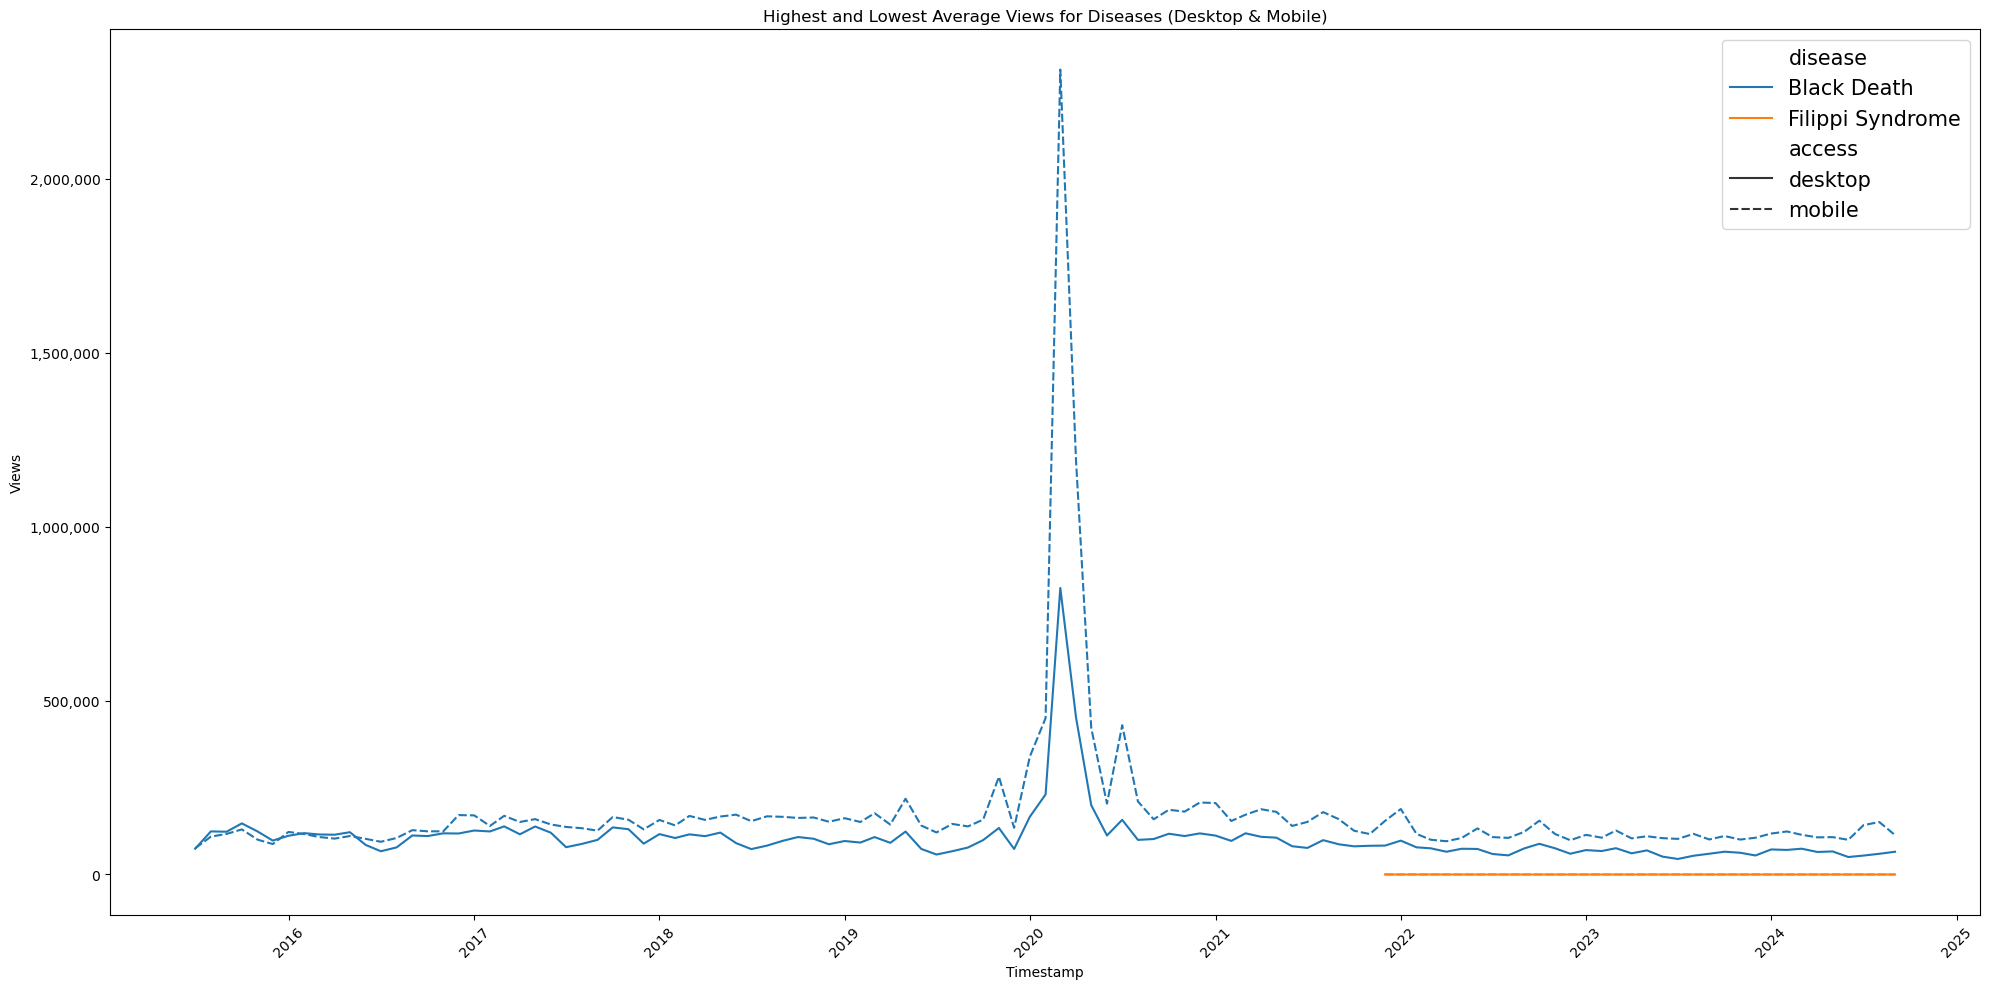

In [37]:
def format_y_axis(x, _):
    return f'{int(x):,}'  # Format with commas for thousands

# Assuming df_combined is already created
df_combined = pd.concat([df1, df2, df3, df4])
df_combined['timestamp'] = pd.to_datetime(df_combined['timestamp'], format='%Y%m%d%H')

plt.figure(figsize=(20, 10))
sns.lineplot(data=df_combined, x='timestamp', y='views', hue='disease', style='access')

plt.xlabel('Timestamp')
plt.ylabel('Views')
plt.title('Highest and Lowest Average Views for Diseases (Desktop & Mobile)')

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis))

plt.xticks(rotation=45)
plt.legend(prop={'size': 15})

plt.tight_layout()

plt.savefig("max_avg_min_avg.png")
plt.show()
plt.close()

#### Top 10 Peak Page Views

This graph displays the time series of the top 10 articles with the highest page views (for desktop and mobile access).

The obtain_max_views function takes a dictionary for parameter,identifies the maximum view count for each article, and returns a dictionary where the key is the dictionary, and the value is the max view for that disease. <br>
After obtaining the dictionary, we sort the dictionary by the value (view counts) in descending order, and retain the top 10 articles with the highest maximum views. 
We repeat the same process for desktop access and mobile access. 

In [38]:
def obtain_max_views(dict1):
    article_max_views = {}
    for disease, entries in dict1.items():
        max_view = 0
        for entry in entries:
            max_view = max(max_view, entry["views"])
            article_max_views[disease] = max_view
    return article_max_views

max_view_desk = obtain_max_views(desktop_views)

ordered_max_view_desk = dict(sorted(max_view_desk.items(), key = lambda item: item[1], reverse = True))

top10_views_desk = dict(itertools.islice(ordered_max_view_desk.items(), 10)) 


In [39]:
max_view_mobile = obtain_max_views(mobile_views)
ordered_max_view_mobile = dict(sorted(max_view_mobile.items(), key = lambda item: item[1], reverse = True))
top10_views_mobile = dict(itertools.islice(ordered_max_view_mobile.items(), 10)) 


The extract_dictionary_subset function takes two dictionaries as parameters and returns a new dictionary the contains the key-value pairs from the first dictionary, where the keys are present in the second dictionary.<br>
This function is used to extract the top 10 peak page view articles, and 10 articles with fewest months of data for both desktop and mobile access. 

In [40]:
def extract_dictionary_subset(dict1, dict2):
    new_dict = {}
    key_list = dict2.keys()
    for keys in key_list:
        new_dict[keys] = dict1[keys]
    return new_dict

In [41]:
top10_articles_desktop = extract_dictionary_subset(desktop_views,top10_views_desk)
top10_articles_mobile = extract_dictionary_subset(mobile_views, top10_views_mobile)

The convert_to_df function takes a dictionary as the parameter, converts it to a DataFrame, retaining only the relevant columns for plotting.

In [42]:
def convert_to_df(dict1):
    columns = ["disease","timestamp","views"]
    df = pd.DataFrame(columns=columns)

    for key, value in dict1.items():
        for item in value:
            data = {"disease": key, "timestamp": item["timestamp"], "views": item["views"]}
            df = pd.concat([df, pd.DataFrame(data, index=[0])], ignore_index=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
    return df

We convert the top 10 articles with the highest page views into a DataFrame and create our plot. We plot both mobile access and desktop access in the same graph. 

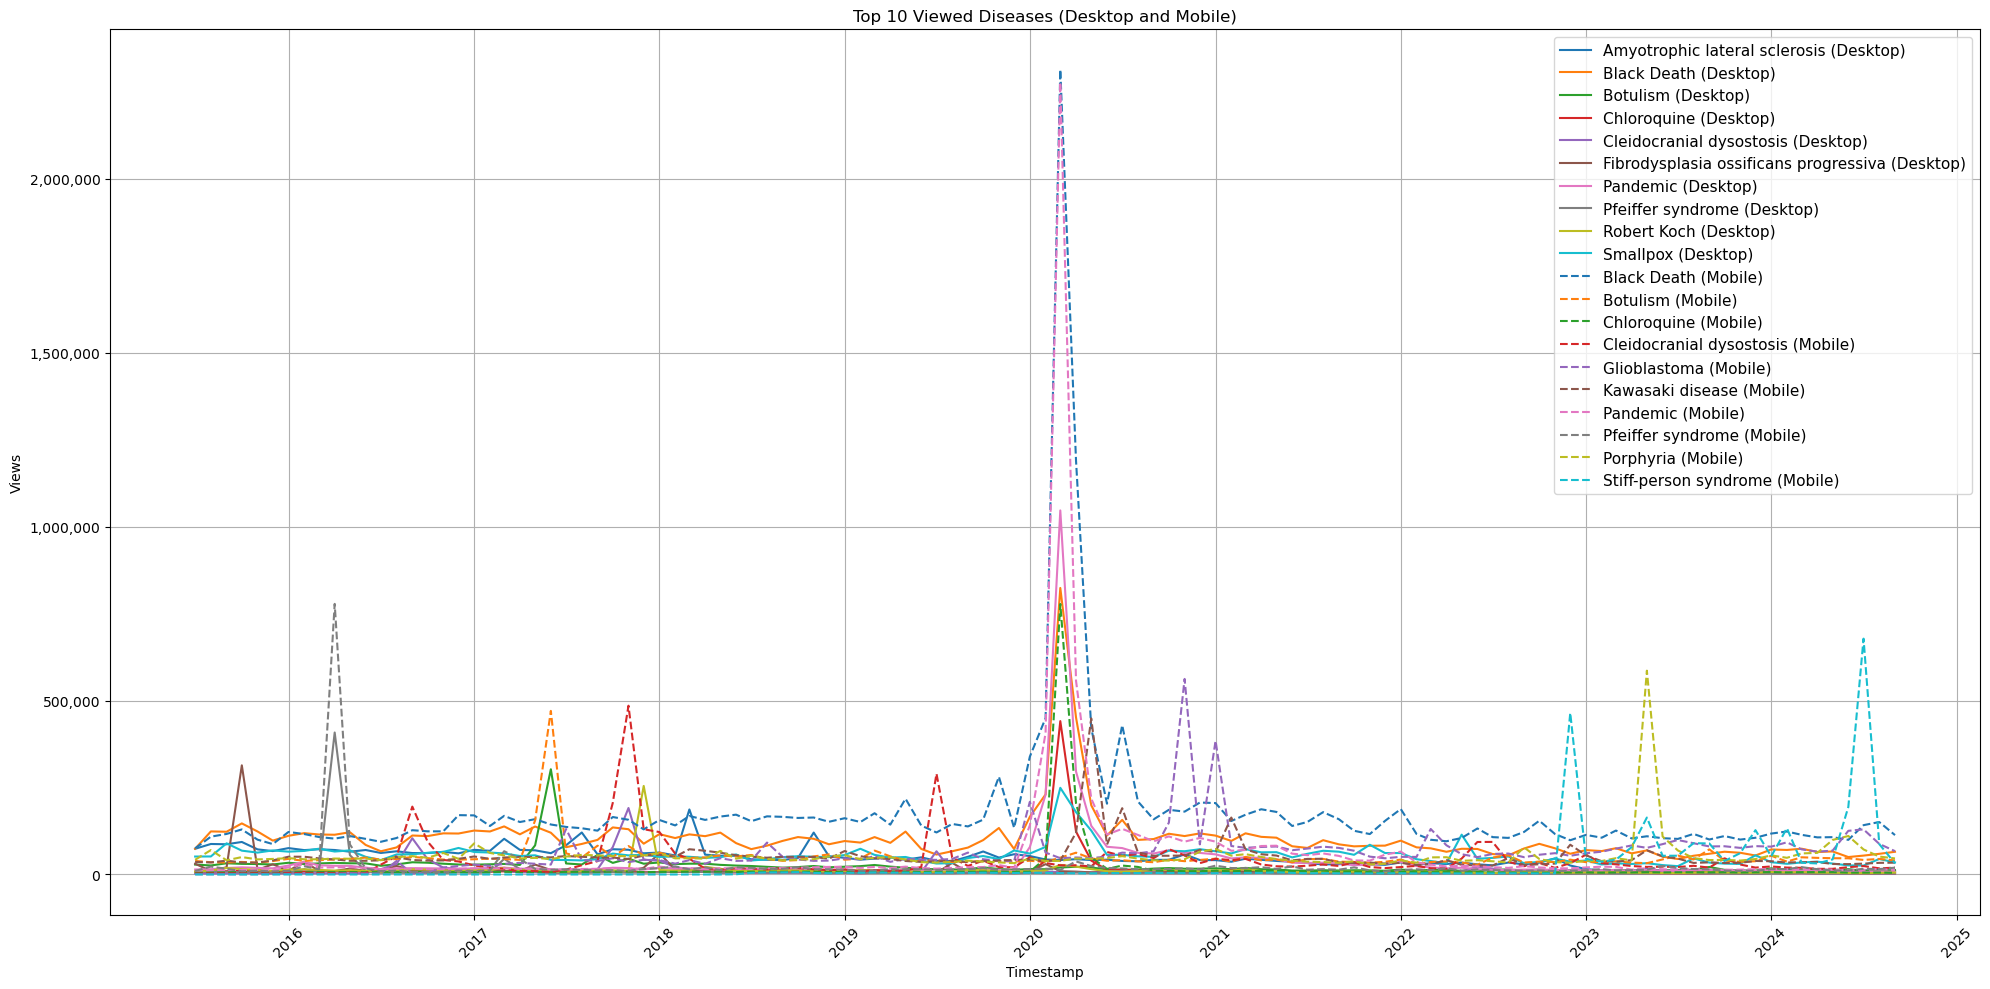

In [50]:
def format_y_axis(x, _):
    return f'{int(x):,}'

# Convert top 10 articles to DataFrames
top10_articles_desktop_df = convert_to_df(top10_articles_desktop)
grouped_desktop = top10_articles_desktop_df.groupby("disease")

plt.figure(figsize=(20, 10))

# Plotting desktop views
# sns.lineplot(data=df_combined, x='timestamp', y='views', hue='disease', style='access')
for disease, group in grouped_desktop:
    plt.plot(group["timestamp"],
             group["views"],
             label=f"{disease} (Desktop)",
             linestyle='-')

# Convert mobile views to DataFrames
top10_articles_mobile_df = convert_to_df(top10_articles_mobile)
grouped_mobile = top10_articles_mobile_df.groupby("disease")

# Plotting mobile views
for disease, group in grouped_mobile:
    plt.plot(group["timestamp"],
             group["views"],
             label=f"{disease} (Mobile)",
             linestyle='--')

# Formatting
plt.xlabel('Timestamp')
plt.ylabel('Views')
plt.title('Top 10 Viewed Diseases (Desktop and Mobile)')
plt.xticks(rotation=45)
plt.legend(prop={'size': 11})
plt.grid()

# Set y-axis formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis))

plt.tight_layout()
plt.savefig("top_10_peak_page_views.png")
plt.show()

#### Fewest Months of Data

This graph displays the time series of the 10 articles with the fewest months of available data (for desktop and mobile access).

The obtain_num_months function takes a dictionary as a parameter and calculates the number of months of data available for each disease. It returns a new dictionary where each key is the disease name, and each value is the corresponding count of available months. <br>
We then sort the dictionary by the value in ascending order, and retain the top 10 articles with the fewest months of available data. <br>
Lastly, we convert the dictionary to a dataframe. <br>
We repeat the same process for desktop access and mobile access. 

In [44]:
# Show 10 articles with the fewest months of data for desktop
# Show 10 articles with the fewest months of data for mobile
def obtain_num_months(dict1):
    num_months ={}
    for key, values in dict1.items():
        num_months[key] = len(values)
    return num_months

num_months_desktop = obtain_num_months(desktop_views)
ordered_num_months_desktop = dict(sorted(num_months_desktop.items(), key = lambda item: item[1], reverse = False))
shortest10_desktop = dict(itertools.islice(ordered_num_months_desktop.items(), 10)) 

num_months_mobile = obtain_num_months(mobile_views)
ordered_num_months_mobile = dict(sorted(num_months_mobile.items(), key = lambda item: item[1], reverse = False))
shortest10_mobile = dict(itertools.islice(ordered_num_months_mobile.items(), 10)) 

In [45]:
fewest_month_desktop = extract_dictionary_subset(desktop_views,shortest10_desktop)
fewest_month_desktop_df = convert_to_df(fewest_month_desktop)
grouped_fewest_desktop = fewest_month_desktop_df.groupby("disease")
fewest_month_mobile = extract_dictionary_subset(mobile_views,shortest10_mobile)
fewest_month_mobile_df = convert_to_df(fewest_month_mobile)
grouped_fewest_mobile = fewest_month_mobile_df.groupby("disease")

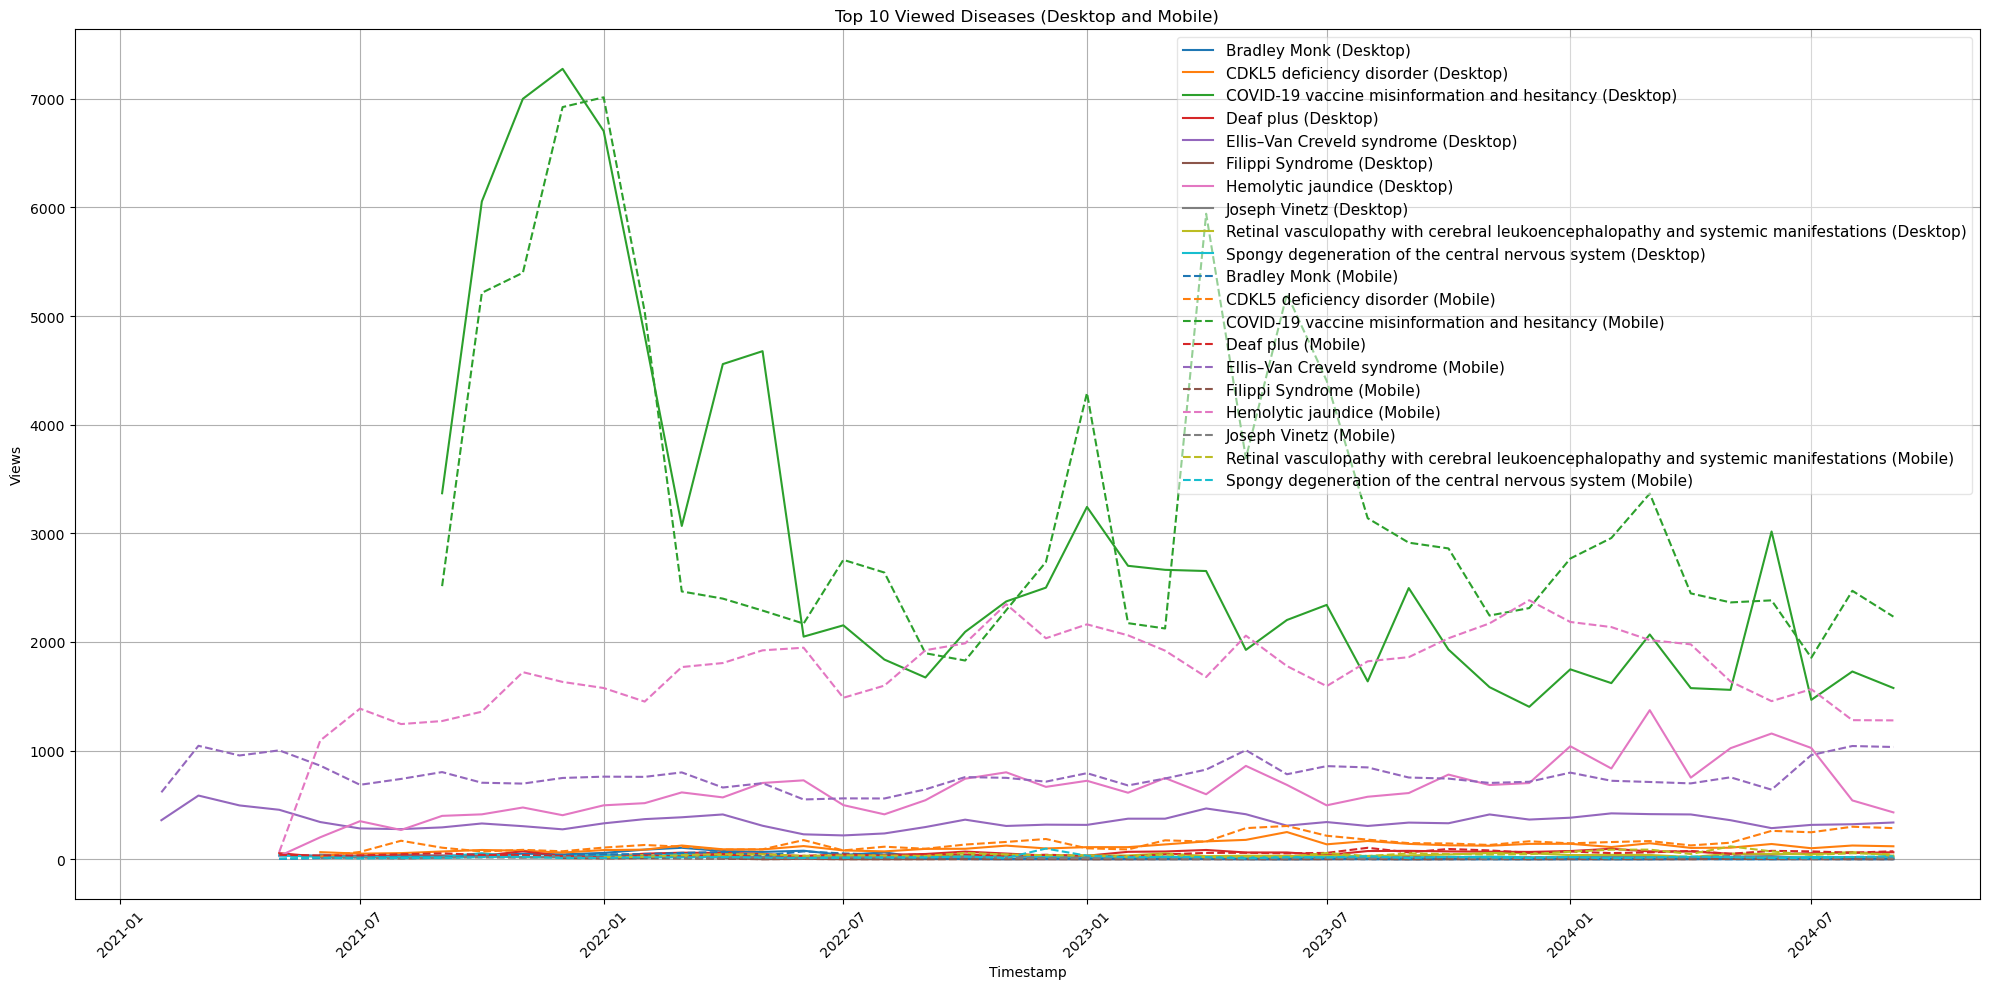

In [49]:
plt.figure(figsize=(20, 10))
for disease, group in grouped_fewest_desktop:
    plt.plot(group["timestamp"],
             group["views"],
             label = f"{disease} (Desktop)",
             linestyle='-')



for disease, group in grouped_fewest_mobile:
    plt.plot(group["timestamp"],
             group["views"],
             label = f"{disease} (Mobile)",
             linestyle='--')


plt.xlabel('Timestamp')
plt.ylabel('Views')
plt.title('Top 10 Viewed Diseases (Desktop and Mobile)')
plt.xticks(rotation=45)
plt.legend(prop={'size': 11}, framealpha=0.5)
plt.grid()

plt.tight_layout()
plt.savefig("fewest_months_of_data.png")
plt.show()
